**현재, 데이터 생성에 있어서 잘못된 부분들이 존재했고, 이로 인해서, 코드가 이상하게 변한 부분들이 존재해서 성능이 제대로 나오지 않는 것 같다.**

데이터를 생성한 이후에는 다시 원본 코드에서 DataLoader만 내가 작성한 것을 가져와서 하는 방식으로 모델을 돌려보자. 


**다 된 이후에는 `ITK-SNAP`을 이용해서 제대로 되는지 돌려봐야 한다.**

일단 freesurfer에서 rebbon을 가져온 뒤에 거기에서부터 시작한다. 

Label의 형식은 GM, WM, CSF 각각 가장 

**Intensity**
- GM : 2
- WM : 3
- CSF : 1

Processing 
0. brainmask.mgz와 ribbon.mgz 파일을 NifTI 파일 형식으로 변환한 이후에, 서로 겹쳐지는 지 확인 
1. 먼저 Crop을 진행한다. 
2. 이후에 GM, WM Mask를 생성 
3. Brain Mask에서 GM, WM Mask를 빼서 CSF Mask를 생성 
4. GM, WM, CSF를 각각 정해진 intensity로 변환한 뒤 하나로 합친다. 

### Libraries

In [1]:
import numpy as np 
import os 
import nibabel as nib
import matplotlib.pyplot as plt
import nibabel.processing

**Functions**

In [11]:
def show_intensity_dist(ndarr):
    print("Max : ", ndarr.max())
    print("Max : ", ndarr.min())
    print("Average : ", ndarr.mean())
    unique, counts = np.unique(ndarr, return_counts=True)
    print(dict(zip(unique, counts)))

In [12]:
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    fig.set_figheight(5)
    fig.set_figwidth(15)
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin='lower')
        axes[i].axis('off')
"""
seg_0 = brain_mask[61, :, :]
seg_1 = brain_mask[:,  61, :]
seg_2 = brain_mask[:, :, 61]
show_slices([seg_0, seg_1, seg_2])
# plt.axis('off')
plt.suptitle("Center slices for Brain Mask image")  
"""

'\nseg_0 = brain_mask[61, :, :]\nseg_1 = brain_mask[:,  61, :]\nseg_2 = brain_mask[:, :, 61]\nshow_slices([seg_0, seg_1, seg_2])\n# plt.axis(\'off\')\nplt.suptitle("Center slices for Brain Mask image")  \n'

**파일 하나 nifti 파일로 생성 후 ITK-SNAP으로 확인**

In [2]:
raw_image = nib.load('./freesurfer/IXI002-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01/mri/brainmask.mgz')
ribbon_image = nib.load('./freesurfer/IXI002-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01/mri/ribbon.mgz')

In [5]:
raw_data = raw_image.get_fdata()
ribbon_data = ribbon_image.get_fdata()

raw_nii = nib.Nifti1Image(raw_data, np.eye(4))
ribbon_nii = nib.Nifti1Image(ribbon_data, np.eye(4))

raw_nii.to_filename('./sample/IXI002_brainmask.nii')
ribbon_nii.to_filename('./sample/IXI002_ribbon.nii')

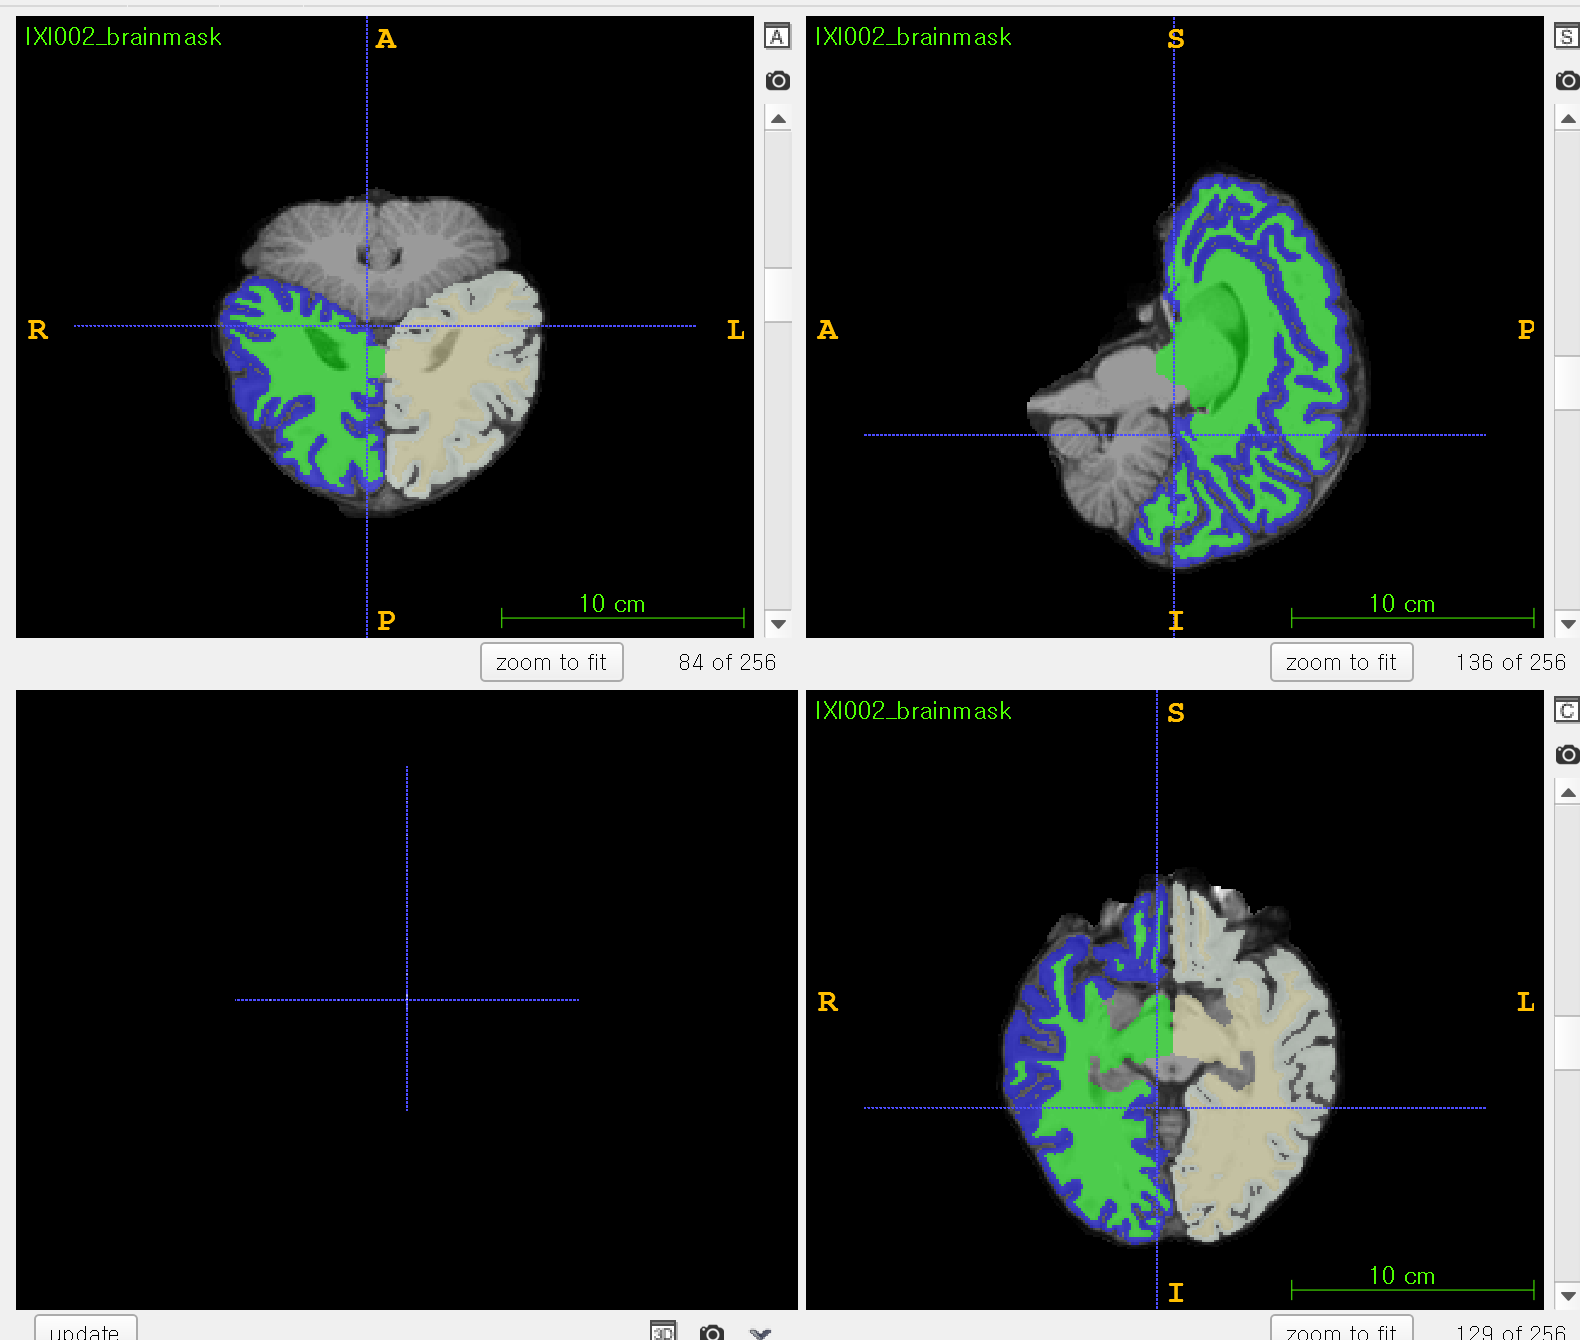

Mask와 Brain MRI가 제대로 겹쳐있는 것을 확인할 수 있다. 

### Cropping

In [6]:
raw_image = nib.load('./freesurfer/IXI017-Guys-0698-IXI3DMPRAG_-s231_-0301-00003-000001-01/mri/brainmask.mgz')
ribbon_image = nib.load('./freesurfer/IXI017-Guys-0698-IXI3DMPRAG_-s231_-0301-00003-000001-01/mri/ribbon.mgz')

In [7]:
raw_data = raw_image.get_fdata()
ribbon_data = ribbon_image.get_fdata()

In [8]:
print(f"raw_data.shape : {raw_data.shape}")
print(f"ribbon_data.shape : {ribbon_data.shape}")

raw_data.shape : (256, 256, 256)
ribbon_data.shape : (256, 256, 256)


In [9]:
crop_raw = raw_data[32:224, 32:224, 32:224]
crop_rib = ribbon_data[32:224, 32:224, 32:224]

In [5]:
raw_nii = nib.Nifti1Image(crop_raw, np.eye(4))
ribbon_nii = nib.Nifti1Image(crop_raw, np.eye(4))

#raw_nii.to_filename('./sample/IXI017_brainmask.nii')
#ribbon_nii.to_filename('./sample/IXI017_ribbon.nii')

이것 역시도 crop만 진행했기 때문에, 별다른 이상은 없다.

### GM, WM Mask 생성

Text(0.5, 0.98, 'Center slices for crop_rib image')

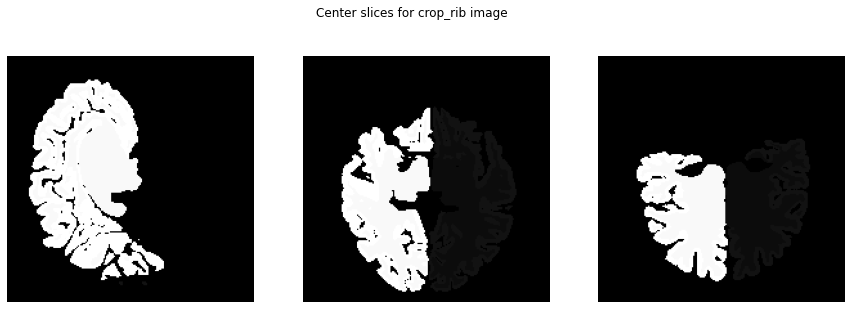

In [13]:
seg_0 = crop_rib[96, :, :]
seg_1 = crop_rib[:,  96, :]
seg_2 = crop_rib[:, :, 96]
show_slices([seg_0, seg_1, seg_2])
# plt.axis('off')
plt.suptitle("Center slices for crop_rib image")  

In [14]:
show_intensity_dist(crop_rib)

Max :  42.0
Max :  0.0
Average :  3.3778218869809753
{0.0: 5988505, 2.0: 292629, 3.0: 252607, 41.0: 289408, 42.0: 254739}


In [15]:
# 각 Intensity 별로 분리
ribbon_label_2 = np.where(crop_rib == 2 , 1, 0)
ribbon_label_3 = np.where(crop_rib == 3 , 1, 0)
ribbon_label_41 = np.where(crop_rib == 41 , 1, 0)
ribbon_label_42 = np.where(crop_rib == 42 , 1, 0)

# GM, WM Mask 생성 
gm_mask = ribbon_label_3 + ribbon_label_42
wm_mask = ribbon_label_2 + ribbon_label_41

**시각화**

Text(0.5, 0.98, 'Center slices for gm_mask image')

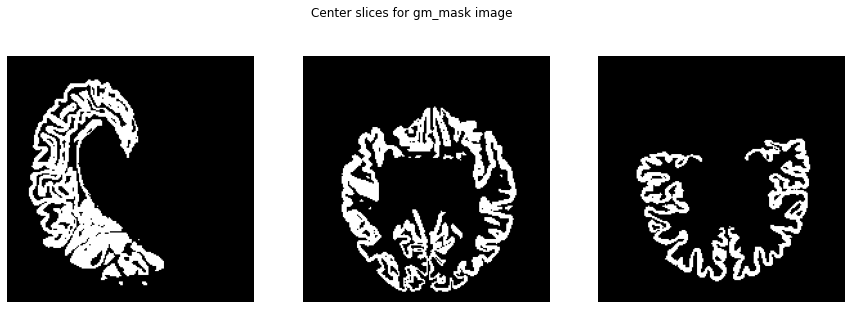

In [16]:
seg_0 = gm_mask[96, :, :]
seg_1 = gm_mask[:,  96, :]
seg_2 = gm_mask[:, :, 96]
show_slices([seg_0, seg_1, seg_2])
# plt.axis('off')
plt.suptitle("Center slices for gm_mask image")  

Text(0.5, 0.98, 'Center slices for wm_mask image')

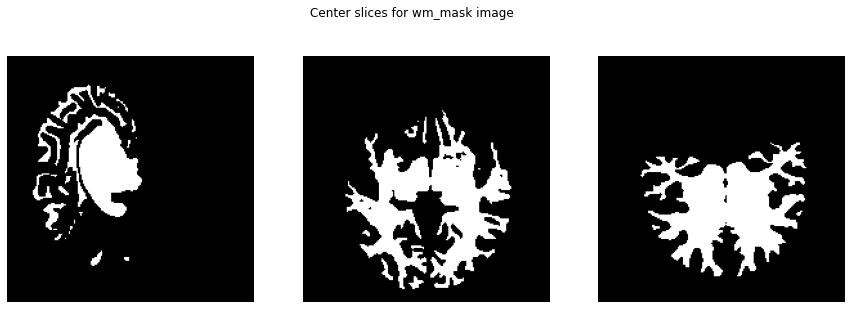

In [17]:
seg_0 = wm_mask[96, :, :]
seg_1 = wm_mask[:,  96, :]
seg_2 = wm_mask[:, :, 96]
show_slices([seg_0, seg_1, seg_2])
# plt.axis('off')
plt.suptitle("Center slices for wm_mask image")  

### CSF Mask 생성

Text(0.5, 0.98, 'Center slices for csf_mask image')

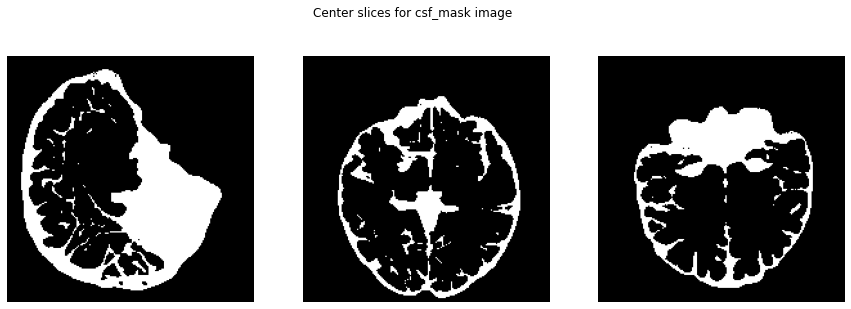

In [18]:
brain_mask = np.where(crop_raw > 0, 1, 0)

#CSF Mask 생성  
csf_mask = brain_mask - gm_mask - wm_mask

# 시각화
seg_0 = csf_mask[96, :, :]
seg_1 = csf_mask[:,  96, :]
seg_2 = csf_mask[:, :, 96]
show_slices([seg_0, seg_1, seg_2])
# plt.axis('off')
plt.suptitle("Center slices for csf_mask image")  

### Label 별로 Intensity 지정하여 Stack

**Intensity**
- GM : 2
- WM : 3
- CSF : 1

In [19]:
gm_mask = np.where(gm_mask == 1, 2, 0)
wm_mask = np.where(wm_mask == 1, 3, 0)
csf_mask = np.where(csf_mask == 1, 1, 0)

total_mask = wm_mask + gm_mask + csf_mask

Text(0.5, 0.98, 'Center slices for total_mask image')

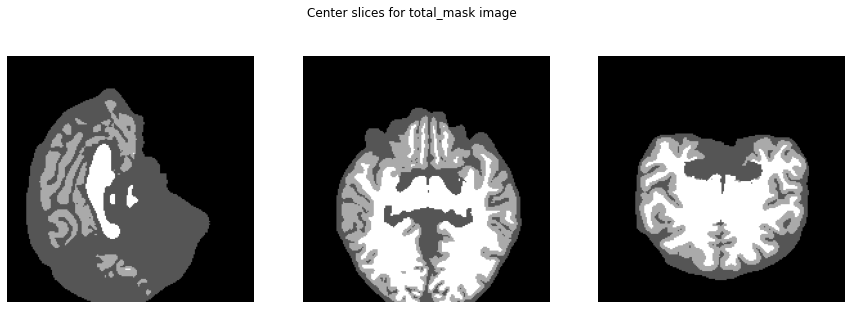

In [20]:
# 시각화
seg_0 = total_mask[96, :, :]
seg_1 = total_mask[:,  96, :]
seg_2 = total_mask[:, :, 96]
show_slices([seg_0, seg_1, seg_2])
# plt.axis('off')
plt.suptitle("Center slices for total_mask image")  

In [21]:
total_nii = nib.Nifti1Image(total_mask, np.eye(4))

total_nii.to_filename('./sample/IXI002_totalmask_192.nii')

### 함수 제작

In [32]:
def intensity_normalize(fdata):
    return (((fdata - fdata.min()) / fdata.max()) * 2) - 1

def make_label(data_dir):
    folder_list = os.listdir(data_dir)
    for folder in folder_list : 
        # Load Image
        raw_image = nib.load(data_dir+folder+'/mri/brainmask.mgz')
        ribbon_image = nib.load(data_dir+folder+'/mri/ribbon.mgz')
        raw_data = raw_image.get_fdata()
        ribbon_data = ribbon_image.get_fdata()
        
        # Cropping
        raw_data = raw_data[32:224, 32:224, 32:224]
        ribbon_data = ribbon_data[32:224, 32:224, 32:224]
        
        # 각 Intensity별로 분리 
        ribbon_label_2 = np.where(ribbon_data == 2 , 1, 0)
        ribbon_label_3 = np.where(ribbon_data == 3 , 1, 0)
        ribbon_label_41 = np.where(ribbon_data == 41, 1, 0)
        ribbon_label_42 = np.where(ribbon_data == 42, 1, 0)
        
        # 각 mask 생성 
        brain_mask = np.where(raw_data > 0, 1, 0)
        
        gm_mask = ribbon_label_3 + ribbon_label_42
        wm_mask = ribbon_label_2 + ribbon_label_41
        csf_mask = brain_mask - gm_mask - wm_mask
        csf_mask = np.where(csf_mask ==1, 1, 0)
        # 각 mask 별 Intensity 할당 
        gm_mask = np.where(gm_mask == 1, 2, 0)
        wm_mask = np.where(wm_mask == 1, 3, 0)
        csf_mask = np.where(csf_mask == 1, 1, 0)
        
        total_mask = gm_mask + wm_mask + csf_mask
        
        # Raw data Normalization
        raw_data = intensity_normalize(raw_data)
        
        raw_nii = nib.Nifti1Image(raw_data, np.eye(4))
        raw_nii.to_filename(f'./TABS_Labeling/Images/{folder[:6]}.nii')
        total_nii = nib.Nifti1Image(total_mask, np.eye(4))
        total_nii.to_filename(f'./TABS_Labeling/Labels/{folder[:6]}.nii')
        
        print(folder[:6] + '\nDone\n')
    print('Done Without Error')
    return 0

In [33]:
make_label('./freesurfer/')

IXI002
Done

IXI012
Done

IXI013
Done

IXI014
Done

IXI015
Done

IXI016
Done

IXI017
Done

IXI019
Done

IXI020
Done

IXI021
Done

IXI022
Done

IXI023
Done

IXI024
Done

IXI025
Done

IXI026
Done

IXI027
Done

IXI028
Done

IXI029
Done

IXI030
Done

IXI031
Done

IXI033
Done

IXI034
Done

IXI035
Done

IXI036
Done

IXI037
Done

IXI038
Done

IXI039
Done

IXI040
Done

IXI041
Done

IXI042
Done

IXI043
Done

IXI044
Done

IXI045
Done

IXI046
Done

IXI048
Done

IXI049
Done

IXI050
Done

IXI051
Done

IXI052
Done

IXI053
Done

IXI054
Done

IXI055
Done

IXI056
Done

IXI057
Done

IXI058
Done

IXI059
Done

IXI060
Done

IXI061
Done

IXI062
Done

IXI063
Done

IXI064
Done

IXI065
Done

IXI066
Done

IXI067
Done

IXI068
Done

IXI069
Done

IXI070
Done

IXI071
Done

IXI072
Done

IXI073
Done

IXI074
Done

IXI075
Done

IXI076
Done

IXI077
Done

IXI078
Done

IXI079
Done

IXI080
Done

IXI081
Done

IXI083
Done

IXI084
Done

IXI085
Done

IXI086
Done

IXI087
Done

IXI088
Done

IXI089
Done

IXI090
Done

IXI091
Done


0

### CSV 파일 목록 생성하기

In [28]:
import pandas as pd 
import numpy as np 
import os 
import nibabel as nib

In [29]:
# 경로 설정 
train_image_path = './data/train/images/'
train_label_path = './data/train/labels/'

val_image_path = './data/val/images/'
val_label_path = './data/val/labels/'

test_image_path = './data/test/images/'
test_label_path = './data/test/labels/'

In [30]:
train_image_list = os.listdir(train_image_path)
train_label_list = os.listdir(train_label_path)

val_image_list = os.listdir(val_image_path)
val_label_list = os.listdir(val_label_path)

test_image_list = os.listdir(test_image_path)
test_label_list = os.listdir(test_label_path)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: './data/train/images/'

In [ ]:
check = nib.load('./TABS_Labeling/Images/IXI091.nii')
check = check.get_fdata()
show_intensity_dist(check)

### For TABS_old

In [1]:
def intensity_normalize(fdata):
    return (((fdata - fdata.min()) / fdata.max()) * 2) - 1

def make_old_label(data_dir):
    folder_list = os.listdir(data_dir)
    for folder in folder_list : 
        # Load Image
        raw_image = nib.load(data_dir+folder+'/mri/brainmask.mgz')
        ribbon_image = nib.load(data_dir+folder+'/mri/ribbon.mgz')
        raw_data = raw_image.get_fdata()
        ribbon_data = ribbon_image.get_fdata()
        
        # Cropping
        raw_data = raw_data[32:224, 32:224, 32:224]
        ribbon_data = ribbon_data[32:224, 32:224, 32:224]
        
        # 각 Intensity별로 분리 
        ribbon_label_2 = np.where(ribbon_data == 2 , 1, 0)
        ribbon_label_3 = np.where(ribbon_data == 3 , 1, 0)
        ribbon_label_41 = np.where(ribbon_data == 41, 1, 0)
        ribbon_label_42 = np.where(ribbon_data == 42, 1, 0)
        
        # 각 mask 생성 
        brain_mask = np.where(raw_data > 0, 1, 0)
        
        gm_mask = ribbon_label_3 + ribbon_label_42
        wm_mask = ribbon_label_2 + ribbon_label_41
        csf_mask = brain_mask - gm_mask - wm_mask
        csf_mask = np.where(csf_mask ==1, 1, 0)
        
        gm_nii = nib.Nifti1Image(gm_mask, np.eye(4))
        wm_nii = nib.Nifti1Image(wm_mask, np.eye(4))
        csf_nii = nib.Nifti1Image(csf_mask, np.eye(4))
        
        gm_nii.to_filename(f'./TABS_old_labeling/gm/{folder[:6]}.nii')
        wm_nii.to_filename(f'./TABS_old_labeling/wm/{folder[:6]}.nii')
        csf_nii.to_filename(f'./TABS_old_labeling/csf/{folder[:6]}.nii')

        
        print(folder[:6] + '\nDone\n')
    print('Done Without Error')
    return 0

In [4]:
make_old_label('./freesurfer/')

IXI002
Done

IXI012
Done

IXI013
Done

IXI014
Done

IXI015
Done

IXI016
Done

IXI017
Done

IXI019
Done

IXI020
Done

IXI021
Done

IXI022
Done

IXI023
Done

IXI024
Done

IXI025
Done

IXI026
Done

IXI027
Done

IXI028
Done

IXI029
Done

IXI030
Done

IXI031
Done

IXI033
Done

IXI034
Done

IXI035
Done

IXI036
Done

IXI037
Done

IXI038
Done

IXI039
Done

IXI040
Done

IXI041
Done

IXI042
Done

IXI043
Done

IXI044
Done

IXI045
Done

IXI046
Done

IXI048
Done

IXI049
Done

IXI050
Done

IXI051
Done

IXI052
Done

IXI053
Done

IXI054
Done

IXI055
Done

IXI056
Done

IXI057
Done

IXI058
Done

IXI059
Done

IXI060
Done

IXI061
Done

IXI062
Done

IXI063
Done

IXI064
Done

IXI065
Done

IXI066
Done

IXI067
Done

IXI068
Done

IXI069
Done

IXI070
Done

IXI071
Done

IXI072
Done

IXI073
Done

IXI074
Done

IXI075
Done

IXI076
Done

IXI077
Done

IXI078
Done

IXI079
Done

IXI080
Done

IXI081
Done

IXI083
Done

IXI084
Done

IXI085
Done

IXI086
Done

IXI087
Done

IXI088
Done

IXI089
Done

IXI090
Done

IXI091
Done


0